In [33]:
# Step 1: Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Import necessary libraries
import os
import json
import pandas as pd

# Define paths to the image folder and caption file
image_folder = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/Flicker8k_Dataset'
caption_file = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/BAN-Cap_captiondata.json'

# Load captions from JSON file
with open(caption_file, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Convert captions data to a DataFrame for easier processing
captions_list = []
for entry in captions_data:
    if 'caption_id' in entry and 'bengali_caption' in entry:
        filename = entry['caption_id'].split('#')[0]  # Extract filename without the caption number
        caption = entry['bengali_caption']
        captions_list.append({"filename": filename, "caption": caption})

# Create a DataFrame
df = pd.DataFrame(captions_list)
print(f"Total captions loaded: {len(df)}")


Total captions loaded: 40455


In [35]:
# Filter image files in the image folder
image_filenames = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
captions = []

# Match images with corresponding captions
for filename in image_filenames:
    matching_captions = df[df['filename'] == filename]['caption'].tolist()
    if len(matching_captions) >= 2:  # Only use images with at least 2 captions
        captions.append(matching_captions[0])  # Use the first caption

# Ensure the dataset is not empty
assert len(captions) > 0, "No captions found!"
assert len(image_filenames) == len(captions), "Mismatch between images and captions!"
print(f"Total images matched with captions: {len(image_filenames)}")


Total images matched with captions: 8091


In [36]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Define a Dataset class for loading images and captions
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_folder, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        # Load image
        image_path = os.path.join(self.image_folder, self.image_filenames[index])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Load caption
        caption = self.captions[index]

        return image, caption

# Instantiate the dataset
dataset = ImageTextDataset(image_filenames, captions, image_folder)
print(f"Dataset size: {len(dataset)}")


Dataset size: 8091


In [37]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define dataloaders with appropriate batch size
batch_size = 32
num_workers = os.cpu_count()  # Use available CPU cores

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")


Training set size: 6472, Validation set size: 1619


In [38]:
import torch
from transformers import AutoTokenizer, AutoModel, ViTModel, ViTFeatureExtractor

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained Vision Transformer (ViT) model
vit_model_name = 'google/vit-base-patch16-224'
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)
vit_model = ViTModel.from_pretrained(vit_model_name).to(device)
image_embedding_size = vit_model.config.hidden_size

# Load pre-trained Bangla BERT model
bangla_bert_name = 'sagorsarker/bangla-bert-base'
text_tokenizer = AutoTokenizer.from_pretrained(bangla_bert_name)
text_model = AutoModel.from_pretrained(bangla_bert_name).to(device)
text_embedding_size = text_model.config.hidden_size


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
import torch.nn as nn

# Define a Projection class with dropout to reduce overfitting
class Projection(nn.Module):
    def __init__(self, input_size, output_size):
        super(Projection, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(output_size, output_size)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

# Create projection layers for image and text embeddings
shared_embedding_size = 512
image_projector = Projection(image_embedding_size, shared_embedding_size).to(device)
text_projector = Projection(text_embedding_size, shared_embedding_size).to(device)


In [40]:
import torch.nn.functional as F

# Define contrastive loss function using cosine similarity
def contrastive_loss(image_proj, text_proj, margin=0.2):
    # Compute cosine similarity between each pair of image and text embeddings
    similarity = F.cosine_similarity(image_proj, text_proj)

    # Contrastive loss based on the margin
    loss = 1 - similarity.mean() + margin
    return loss


In [41]:
import itertools
import torch.optim as optim

# Set up optimizer with weight decay for regularization
params = [
    {"params": vit_model.parameters(), "lr": 1e-4},
    {"params": text_model.parameters(), "lr": 1e-5},
    {"params": itertools.chain(image_projector.parameters(), text_projector.parameters()), "lr": 1e-3, "weight_decay": 1e-3}
]
optimizer = optim.AdamW(params, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.8)


In [43]:
from PIL import Image


In [44]:
!pip install pillow


In [45]:
# Import tqdm for progress bar
from tqdm import tqdm

# Training and validation loop
num_epochs = 1
best_val_loss = float("inf")
early_stopping_counter = 0
early_stopping_patience = 3

for epoch in range(num_epochs):
    # Training phase
    vit_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_train_loss = 0.0

    # Training loop with progress bar
    train_progress = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", colour="green")
    for images, captions in train_progress:
        optimizer.zero_grad()
        images = images.to(device)

        # Process captions
        inputs = text_tokenizer(captions, return_tensors='pt', padding="max_length", max_length=32, truncation=True).to(device)
        text_embeddings = text_projector(text_model(**inputs).last_hidden_state[:, 0, :])

        # Process images
        image_embeddings = image_projector(vit_model(pixel_values=images)["last_hidden_state"][:, 0, :])

        # Compute loss and backpropagate
        loss = contrastive_loss(image_embeddings, text_embeddings)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_progress.set_postfix({"Train Loss": total_train_loss / len(train_dataloader)})

    # Validation phase
    vit_model.eval()
    text_model.eval()
    image_projector.eval()
    text_projector.eval()
    total_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    val_progress = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", colour="green")
    with torch.no_grad():
        for images, captions in val_progress:
            images = images.to(device)
            inputs = text_tokenizer(captions, return_tensors='pt', padding="max_length", max_length=32, truncation=True).to(device)
            text_embeddings = text_projector(text_model(**inputs).last_hidden_state[:, 0, :])
            image_embeddings = image_projector(vit_model(pixel_values=images)["last_hidden_state"][:, 0, :])
            val_loss = contrastive_loss(image_embeddings, text_embeddings)
            total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_dataloader)
            cosine_sim = F.cosine_similarity(text_embeddings, image_embeddings)
            correct_predictions += (cosine_sim > 0.9).sum().item()
            total_predictions += images.size(0)
            val_progress.set_postfix({"Val Loss": avg_val_loss, "Accuracy": correct_predictions / max(1, total_predictions)})

    # Epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_train_loss / len(train_dataloader):.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {correct_predictions / max(1, total_predictions):.4f}")

    # Adjust learning rate
    lr_scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break


Epoch [1/1] - Validation: 100%|██████████| 51/51 [02:29<00:00,  2.93s/it, Val Loss=0.2, Accuracy=1]

Epoch [1/1] - Train Loss: 0.2196, Val Loss: 0.2001, Accuracy: 1.0000


#Interface for Bangla bert + VIT

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# Ensure models are in evaluation mode
vit_model.eval()
image_projector.eval()
text_model.eval()
text_projector.eval()

# Function to create image embeddings with rescaling for ViT model compatibility
def create_image_embeddings(images):
    with torch.no_grad():
        # Rescale the pixel values from [-1, 1] to [0, 1]
        images = (images + 1) / 2  # Adjusts values to be in the [0, 1] range
        features = vit_feature_extractor(images=images, return_tensors="pt").to(device)
        image_embeddings = vit_model(**features).last_hidden_state[:, 0, :]
        image_projection = image_projector(image_embeddings)
    return image_projection

# Precompute and store image embeddings for all training images
image_embeddings_list_train = []
for index in tqdm(range(len(train_dataset)), desc="Processing Training Images"):
    images = train_dataset[index][0].unsqueeze(0).to(device)  # Add batch dimension and move to device
    image_projection = create_image_embeddings(images)
    image_embeddings_list_train.append(image_projection[0].cpu())  # Store on CPU to save GPU memory

# Function for image retrieval based on text query
def image_retrieval_function(input_query, n=5, display=False):
    with torch.no_grad():
        # Process text query and create embeddings
        inputs = text_tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=32, truncation=True).to(device)
        text_embeddings = text_model(**inputs).last_hidden_state[:, 0, :]
        text_projection = text_projector(text_embeddings)

    # Compute similarity scores between the query and all stored image embeddings
    similarity_scores_list = []
    for image_projection in image_embeddings_list_train:
        image_projection = image_projection.to(device)
        similarity = F.cosine_similarity(text_projection, image_projection.unsqueeze(0))
        similarity_scores_list.append(similarity.item())

    # Get the indices of the top n most similar images
    max_indexes = np.argsort(similarity_scores_list)[-n:][::-1]

    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]  # Original image from dataset
            plt.imshow(torch.moveaxis(image_tensor, 0, 2))
            plt.title(f"Similarity Score: {similarity_scores_list[index]:.4f}")
            plt.axis('off')
            plt.show()
    else:
        return max_indexes



Processing Training Images: 100%|██████████| 6472/6472 [02:37<00:00, 41.02it/s]


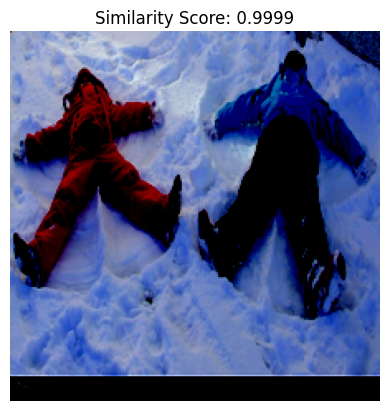

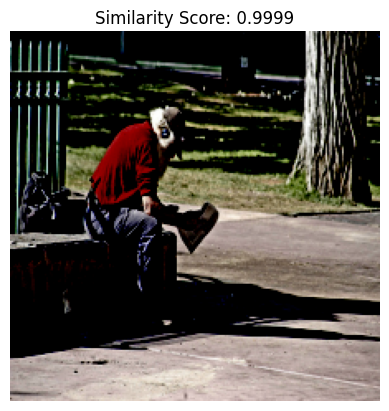

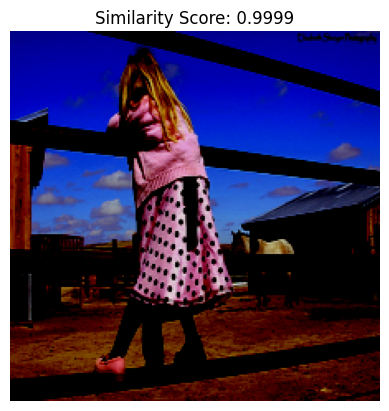

In [47]:
# Example usage
input_query = "কুকুর দৌড়াচ্ছে "  # Bangla text query
image_retrieval_function(input_query, n=3, display=True)